In [84]:
import sys
sys.path.append('..')
from db1 import *

R = PolynomialRing(QQ, 't')
S = PolynomialRing(ZZ, 't')
t = R.gen()

def is_paving(M):
    n = M.size()
    r = M.rank()
    return (len(M.independent_r_sets(r-1)) == binomial(n, r-1))

def q_kl(k, h):
    return kazhdan_lusztig_inverse_uniform(k, h+1) - kazhdan_lusztig_inverse_uniform(k-1, h)

def kl_inverse_fast(M):
    if M.loops(): return R(0)
    k, n = M.rank(), M.size()
    if k == n or k == 0: return R(1)
    if not M.is_connected():
        ans = R(1)
        CC = M.components()
        for N in CC:
            res = M.delete(M.groundset() - N)
            ans = ans * kl_inverse_fast(res)
        return ans

    if is_paving(M):
        return kl_inverse_paving(M)
    if is_paving(M.dual()):
        return kl_inverse_copaving(M)
    """
    if n <= 8 and M.is_connected():
        for i in range(len(mat[n][k])):
            if mat[n][k][i].is_isomorphic(M):
                return ikl[n][k][i]
    """
    LF = M.lattice_of_flats()
    ans = R(0)
    for F in LF:
        if len(F) != n:
            Res = M.delete(M.groundset() - F)
            Con = M.contract(F)
            chi = characteristic_polynomial(Con)(1/t) * t**(Con.rank())
            PPP = kl_inverse_fast(Res)(t) * (-1)**(Res.rank())
            ans = ans + chi * PPP
    assert (t**k * ans(1/t)).numerator() == -ans(t)
    ans = ans.numerator() * (-1)**(k+1)
    return ans.truncate((k+1)//2)

def kazhdan_lusztig_inverse_uniform(k, n):
    if k == n:
        return R(1)
    d = k
    m = n - d
    ans = 0
    for j in range((d-1)//2 + 1):
        ans = ans + m * (d-2*j)/((m+j) * (m+d-j)) * binomial(d, j) * t**j
    return ans * binomial(m+d, d)

def kl_inverse_paving(M):
    assert is_paving(M)
    n = M.size()
    k = M.rank()
    ans = kazhdan_lusztig_inverse_uniform(k, n)
    for H in M.hyperplanes():
        h = len(H)
        if h >= k:
            ans = ans - q_kl(k, h)
    return ans

def kl_inverse_copaving(M):
    assert is_paving(M.dual())
    n = M.size()
    k = M.rank()
    ans = kazhdan_lusztig_inverse_uniform(k, n)
    for H in M.dual().hyperplanes():
        h = len(H)
        if h >= n-k:
            ans = ans - kli_vtilde_dual(n-k, h, n) + kazhdan_lusztig_inverse_uniform(h-n+k+1, h) * kazhdan_lusztig_inverse_uniform(n-h-1, n-h)
    return ans

def kli_vtilde_dual(k, h, n):
    return helper1(n-k, h, n)

def helper1(k, h, n):
    c = n - h
    ans1 = kazhdan_lusztig_inverse_uniform(k, n)
    ans2 = helper2(c, k, n)
    ans3 = kazhdan_lusztig_inverse_uniform(k-c+1, h) * kazhdan_lusztig_inverse_uniform(c-1, c)
    return ans1 - ans2 + ans3

def helper2(c, k, n):
    h = n - c
    ans = 0
    for j in range(k-c+1):
        ans = ans + binomial(n-c, j) * (-1)**(c-1+j) * kazhdan_lusztig_inverse_uniform(c-1, c) * t**(k-c-j+1) * chuly(k-c-j+1, n-c-j)(1/t)
    for i in range(c-1):
        for j in range(k-i):
            ans = ans + binomial(c, i) * binomial(n-c, j) * (-1)**(i+j) * t**(k-i-j) * helper4(c, k, n, i, j)(1/t)
    ans = ans.numerator().truncate((k-1)//2 + 1)
    if ans[0] < 0:
        ans = -ans
    return ans

def helper3(c, k, n):
    ans = 0
    for j in range(k-c+1):
        ans = ans + binomial(n-c, j) * uniformKLpoly(c-1, c) * (-1)**(k-c-j+1) * kazhdan_lusztig_inverse_uniform(k-c-j+1, n-c-j)
    for i in range(c-1):
        for j in range(k-i):
            ans = ans + binomial(c, i) * binomial(n-c, j) * (-1)**(k-i-j) * helper2(c-i, k-i-j, n-i-j)
    return -ans

def helper4(c, k, n, i, j):
    ans = 0
    for l in range(c-i-1):
        ans = ans + (-1)**l * (t-1)**(max(n-i-j-l-1, 0))
    for u in range(n-k-1):
        ans = doit_once(ans)
    return ans

def chuly(a, b):
    ans = (t-1)**b
    for i in range(b-a):
        ans = doit_once(ans)
    return ans

def doit_once(p):
    p = p // t**2
    p = p * t
    p = p - p(1)
    return p

def lorenzo(k, h, n):
    c = n - h
    ans1 = uniformKLpoly(k, n) + uniformKLpoly(k-c+1, h) * uniformKLpoly(c-1, c)
    ans2 = helper3(c, k, n)
    return ans1 - ans2

In [85]:
def parallel_connection(m, n):
    G = graphs.CycleGraph(m + n - 2)
    G.add_edge(0, m-1)
    edge_e = frozenset({(0, m - 1)})
    return G, edge_e

def leading_term(p):
    return p.leading_coefficient() * t ** p.degree()

def lt(M):
    r = M.rank()
    if r % 2 == 1:
        return leading_term(kl_inverse_fast(M))
    else:
        return 0

def circuits_containing_element(M, e):
    circuits_with_e = set()
    circuits_with_e = set(circuit for circuit in M.circuits() if e.issubset(set(circuit)) and not any(circuit.issubset(y) for y in circuits_with_e))
    return circuits_with_e

def sum_at_Circuits(M, C, e):
    sum = 0
    for c in C:
        sum += t * kl_inverse_fast(M.contract(c).simplify()) * lt(M.delete(M.groundset() - c).contract(e).simplify())
    return sum

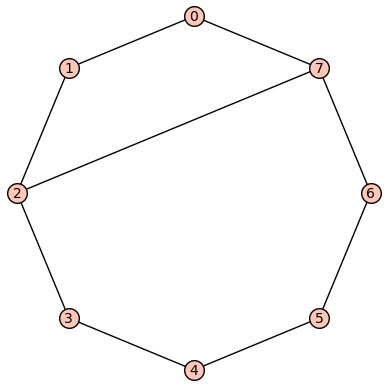

[frozenset({(0, 1), (0, 7), (1, 2), (2, 7)})]


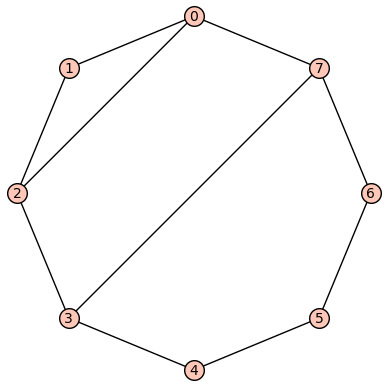

[frozenset({(0, 1), (0, 2), (1, 2)}), frozenset({(2, 3), (0, 7), (0, 2), (3, 7)}), frozenset({(0, 1), (0, 7), (2, 3), (1, 2), (0, 2), (3, 7)}), frozenset({(0, 7), (3, 4), (3, 7), (2, 3), (6, 7), (0, 2), (4, 5), (5, 6)})]


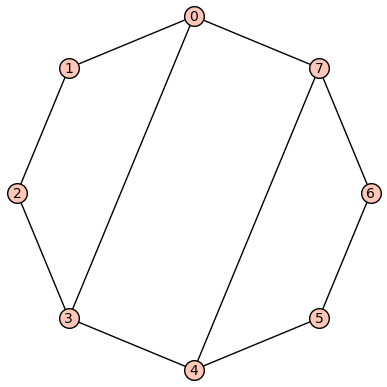

[frozenset({(0, 7), (0, 3), (4, 7), (3, 4)}), frozenset({(2, 3), (1, 2), (0, 3), (0, 1)}), frozenset({(0, 1), (0, 7), (2, 3), (1, 2), (3, 4), (0, 3), (4, 7)}), frozenset({(0, 7), (6, 7), (4, 5), (3, 4), (5, 6), (0, 3), (4, 7)})]


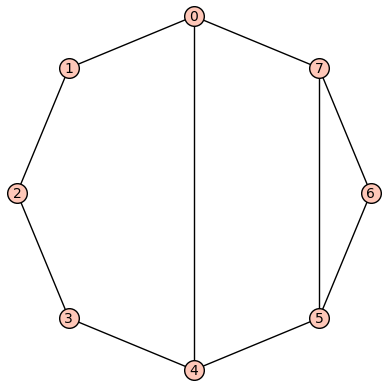

[frozenset({(0, 7), (4, 5), (0, 4), (5, 7)}), frozenset({(0, 1), (2, 3), (1, 2), (0, 4), (3, 4)}), frozenset({(0, 7), (6, 7), (4, 5), (0, 4), (5, 6), (5, 7)}), frozenset({(0, 1), (0, 7), (1, 2), (0, 4), (3, 4), (5, 7), (2, 3), (4, 5)})]


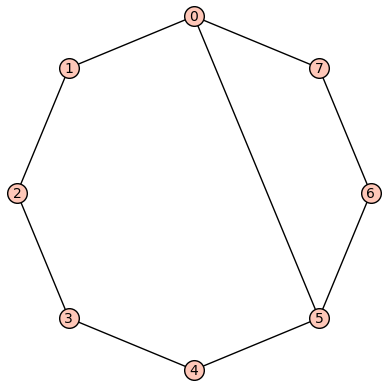

[frozenset({(0, 7), (6, 7), (5, 6), (0, 5)}), frozenset({(0, 1), (2, 3), (4, 5), (1, 2), (3, 4), (0, 5)})]
+---+------------------------------+-----------------------------+-----------------------------+---------------------+-----------------------+----------------------+-----------------------+
| k |             QMn              |            QMdel1           |            Qdiff            |         Qcon        |        diffQcon       |      extra term      |          et2          |
+---+------------------------------+-----------------------------+-----------------------------+---------------------+-----------------------+----------------------+-----------------------+
| 1 | 14*t^3 + 38*t^2 + 38*t + 15  |       5*t^2 + 9*t + 5       | 14*t^3 + 33*t^2 + 29*t + 10 |  14*t^2 + 19*t + 10 |           0           |          0           |           0           |
| 2 |  (t + 1) * (7*t^2 + 28*t +   | 10*t^3 + 32*t^2 + 41*t + 16 |  -3*t^3 + 3*t^2 + 11*t + 8  | (t + 1) * (3*t + 8) | -6*t^3 - 11*t^

In [86]:
S = PolynomialRing(ZZ, 't')

def polys(M, e):
    QMn = S(kl_inverse_fast(M))
    QMdel = S(kl_inverse_fast(M.delete(e)))
    Qdiff = S(QMn - QMdel)
    Qcon = S(kl_inverse_fast(M.contract(e)))
    diffQcon = Qdiff - S(t + 1) * Qcon
    extra_term = sum_at_Circuits(M, circuits_containing_element(M, e), e)
    return QMn, QMdel, Qdiff, Qcon, diffQcon, extra_term

from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["k", "QMn", "QMdel1", "Qdiff", "Qcon", "diffQcon", "extra term", "et2"]
table2 = PrettyTable()
table2.field_names = ["k", "QMn", "QMdel2", "Qdiff", "Qcon", "diffQcon", "extra term"]

"""
n = 9
for k in range (1, n-1):
    G = graphs.CycleGraph(n)
    G.add_edges([(0,k), (k, n-1)])
    e1, e2 = frozenset({(0, k)}), frozenset({(k, n-1)})
    #G.show(figsize=[3, 3])
    M = Matroid(G)
    QMn1, QMdel1, Qdiff1, Qcon1, diffQcon1, extra_term1 = polys(M, e1)
    QMn2, QMdel2, Qdiff2, Qcon2, diffQcon2, extra_term2 = polys(M, e2)
    table.add_row([k, QMn1.factor(), QMdel1.factor(), Qdiff1, Qcon1.factor(), diffQcon1, extra_term1])
    table2.add_row([k, QMn2.factor(), QMdel2.factor(), Qdiff2, Qcon2.factor(), diffQcon2, extra_term2])

table.max_width = 25
table2.max_width = 25

print(table, table2)
"""

n = 8
for k in range (1, n-2):
    G = graphs.CycleGraph(n)
    G.add_edges([(0,k), (k+1, n-1)])
    e1, e2 = frozenset({(0, k)}), frozenset({(k+1, n-1)})
    G.show()
    M = Matroid(G).simplify()
    cc = M.circuit_closures()
    et2 = [x for c in cc.keys() for x in cc[c] if set(e1).issubset(x) and set(x) != M.groundset()]
    print(et2)
    et2sum = sum_at_Circuits(M, et2, e1)
    QMn1, QMdel1, Qdiff1, Qcon1, diffQcon1, extra_term1 = polys(M, e1)
    table.add_row([k, QMn1.factor(), QMdel1.factor(), Qdiff1, Qcon1.factor(), diffQcon1, extra_term1, et2sum])

table.max_width = 28
table2.max_width = 28
print(table)

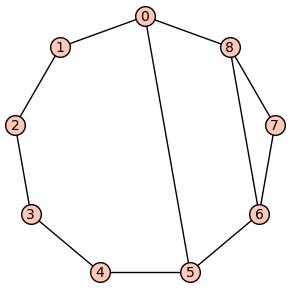

{frozenset({(0, 8), (6, 8), (5, 6), (0, 5)}), frozenset({(0, 1), (1, 2), (3, 4), (2, 3), (4, 5), (0, 5)}), frozenset({(6, 7), (5, 6), (0, 5), (0, 8), (7, 8)})}
10*t^3 + 8*t^2


{frozenset({(0, 5), (0, 8), (5, 6), (6, 8)}): (5*t + 4, 0),
 frozenset({(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)}): (t + 4, 0),
 frozenset({(0, 5), (0, 8), (5, 6), (6, 7), (7, 8)}): (5*t + 4, 2*t)}

In [87]:
n = 9
k = 5
G = graphs.CycleGraph(n)
G.add_edges([(0,k), (k+1, n-1)])
e1, e2 = frozenset({(0, k)}), frozenset({(k+1, n-1)})
G.show(figsize=[3, 3])
M = Matroid(G)
C = circuits_containing_element(M, e1)
print(C)
print(sum_at_Circuits(M, C, e1))
decomp = {}
for c in C:
    decomp[c] = (kl_inverse_fast(M.contract(c).simplify()), lt(M.delete(M.groundset() - c).contract(e1).simplify()))
decomp

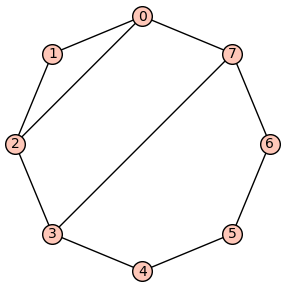

{frozenset({(0, 1), (0, 2), (1, 2)}), frozenset({(0, 7), (3, 4), (2, 3), (6, 7), (0, 2), (4, 5), (5, 6)}), frozenset({(2, 3), (0, 7), (0, 2), (3, 7)})}
-6*t^3 - 11*t^2 - 8*t


{frozenset({(0, 1), (0, 2), (1, 2)}): (3*t^2 + 11*t + 8, 1, 1),
 frozenset({(0, 2), (0, 7), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7)}): (1,
  5*t^2,
  5*t^2 + 9*t + 5),
 frozenset({(0, 2), (0, 7), (2, 3), (3, 7)}): (2*t + 3, 0, 2)}

In [88]:
n = 8
k = 2
G = graphs.CycleGraph(n)
G.add_edges([(0,k), (k+1, n-1)])
e1, e2 = frozenset({(0, k)}), frozenset({(k+1, n-1)})
G.show(figsize=[3, 3])
M = Matroid(G)
C = circuits_containing_element(M, e1)
print(C)
print(polys(M, e1)[4])
decomp = {}
for c in C:
    decomp[c] = (kl_inverse_fast(M.contract(c).simplify()), lt(M.delete(M.groundset() - c).contract(e1).simplify()), kl_inverse_fast(M.delete(M.groundset() - c).contract(e1).simplify()))
decomp

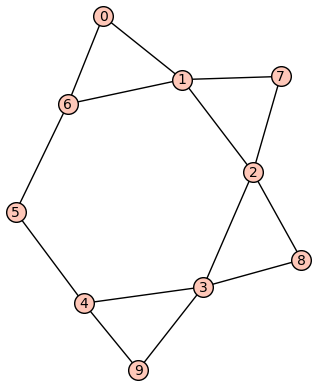

In [89]:
# Create a saw graph with S(6, 4)
G = graphs.CycleGraph(7)
G.add_vertices([6, 7, 8, 9])
edges = [(0, 6), (1, 6), (1, 7), (2, 7), (2, 8), (3, 8), (3, 9), (4, 9)]
e1, e2, e3, e4 = frozenset({(0,1)}), frozenset({(1,2)}), frozenset({(2,3)}), frozenset({(3,4)})
G.add_edges(edges)
G.show()

In [90]:
polys(Matroid(G), e1)

(9*t^4 + 109*t^3 + 208*t^2 + 176*t + 80,
 31*t^3 + 88*t^2 + 84*t + 40,
 9*t^4 + 78*t^3 + 120*t^2 + 92*t + 40,
 31*t^3 + 88*t^2 + 84*t + 40,
 -22*t^4 - 41*t^3 - 52*t^2 - 32*t,
 46*t^4 + 41*t^3 + 52*t^2 + 32*t)